# EchoSpike Predictive Plasticity

In [1]:
import matplotlib.pyplot as plt
from utils import  test, train
from main import Args
from data import load_SHD
from model import EchoSpike, simple_out
import numpy as np
import torch
import seaborn as sns
from scipy.signal import savgol_filter
from tqdm.notebook import trange
import pickle
color_list = sns.color_palette('muted')
device = 'cpu'
epochs = 1
n_inputs = 700 # 28*28 #34 * 34 * 2
n_outputs = 20
batch_size = 64
folder = 'models/'
model_name = folder + 'shd_stacked_paper2_epoch640.pt'
# with open(model_name[:-3] + '_args.pkl', 'rb') as f:
#     args = pickle.load(f)
args = Args()
n_hidden = args.n_hidden#  3 * [512]
print(vars(args))

/home/lars/miniconda3/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/lars/miniconda3/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in

{'model_name': 'nmnist_3layer_allclapp', 'dataset': 'shd', 'online': False, 'device': 'cpu', 'recurrency_type': 'stacked', 'lr': 0.0001, 'epochs': 3, 'batch_size': 64, 'n_hidden': [512, 512, 512], 'c_y': [0.0008, -0.0004], 'n_inputs': 700, 'n_outputs': 20, 'n_time_bins': 100, 'beta': 0.95}


## Dataset
Spiking Heidelberg Digits

/home/lars/ownCloud/ETH/Master/Project_2/SNN_CLAPP/data.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


torch.Size([100, 1, 700]) tensor([4.])
torch.Size([100, 1, 700]) tensor([10.])
torch.Size([100, 1, 700]) tensor([6.])


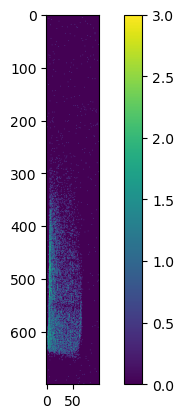

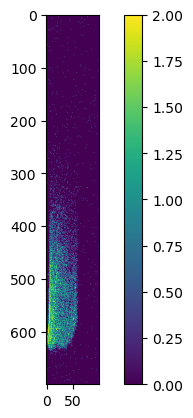

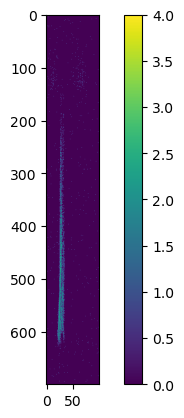

In [6]:

#train_loader, test_loader = load_PMNIST(n_time_bins, scale=0.9, patches=True) #load_NMNIST(n_time_bins, batch_size=batch_size)
n_time_bins = 100
train_loader, test_loader = load_SHD(batch_size=batch_size) #load_NMNIST(n_time_bins, batch_size=batch_size)
# Plot Example
for i in range(3):
    frames, target = train_loader.next_item(-1, contrastive=True)
    plt.figure()
    plt.imshow(frames.squeeze(1).T)
    plt.colorbar()
    print(frames.shape, target)


## Load pretrained model

In [3]:
SNN = EchoSpike(n_inputs, n_hidden, beta=0.95, device=args.device, recurrency_type=args.recurrency_type, online=args.online).to(device)
# state_dict = torch.load(model_name, map_location=args.device)
# state_dict = {key.replace('clapp', 'layers'):value for key, value in state_dict.items()}
# # overwrite the state dict
# torch.save(state_dict, model_name)
SNN.load_state_dict(torch.load(model_name, map_location=args.device))
# train(SNN, train_loader, 1, 'cpu', 'none', batch_size=batch_size, temporal=True, online=True)
from_epoch = 0
echo_train_loss = torch.load(model_name[:-3]+'_clapp_loss_hist.pt', map_location='cpu')[int(from_epoch*len(train_loader)/batch_size):]
print(echo_train_loss.shape)
for i in range(echo_train_loss.shape[-1]):
    plt.plot(from_epoch+(batch_size*np.arange(echo_train_loss.shape[0])/len(train_loader)), savgol_filter(echo_train_loss[:,i], 199, 1))
plt.legend([f'layer {i+1}' for i in range(len(SNN.layers))])
# plt.ylim([-3.,-2])
plt.xlabel('Epoch')
plt.ylabel('Echo Loss')

FileNotFoundError: [Errno 2] No such file or directory: 'models/shd_stacked_paper2_epoch640_clapp_loss_hist.pt'

# Analyze Weights Directly

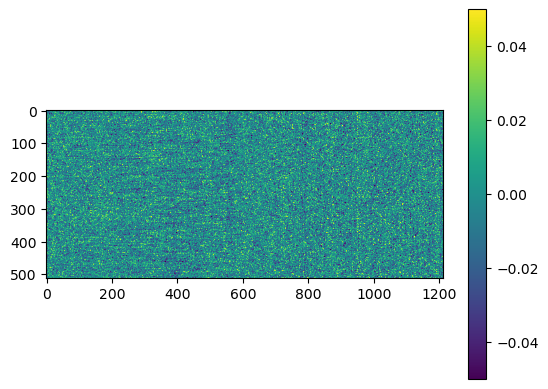

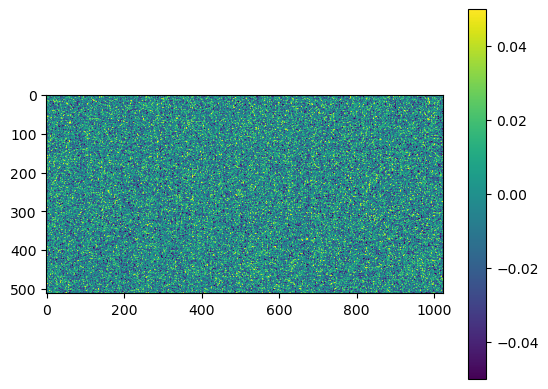

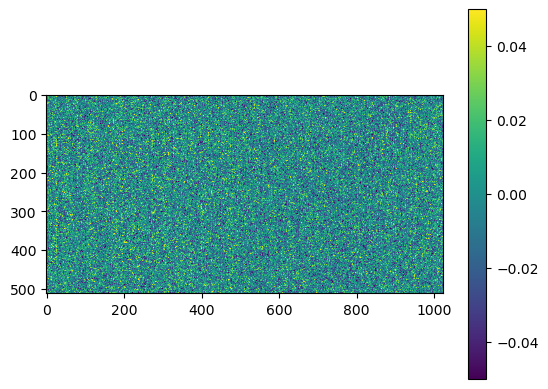

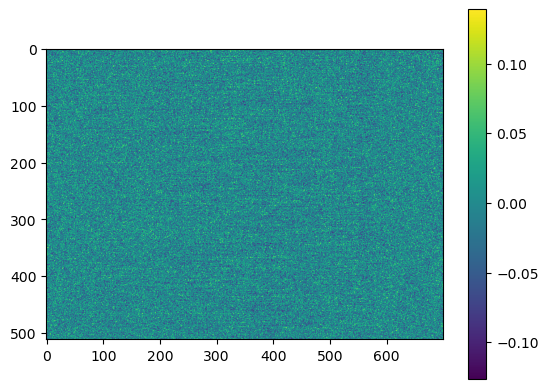

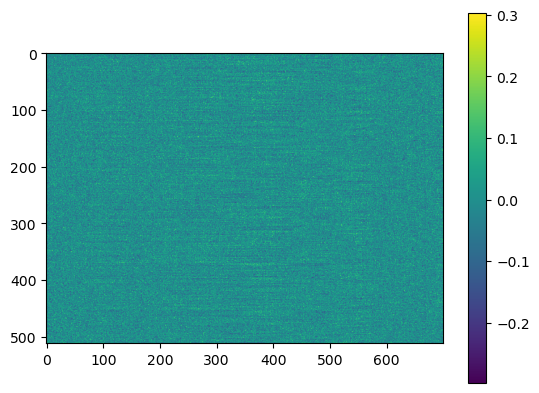

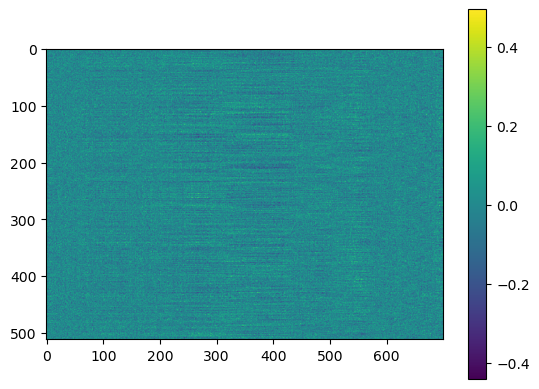

In [5]:
layers = [SNN.layers[0].fc.weight[:,:n_inputs]]
for i in range(1, len(SNN.layers)):
    layers.append(SNN.layers[i].fc.weight[:,:n_hidden[i-1]] @ layers[-1])

for i in range(len(SNN.layers)):
    plt.figure()
    plt.imshow(SNN.layers[i].fc.weight.detach(), vmax=0.05, vmin=-0.05)
    plt.colorbar()
    # plt.figure()
    # plt.imshow(SNN.layers[i].pred.weight.detach(), vmax=0.5, vmin=-0.5)
    # plt.colorbar()
for lay in layers:
    plt.figure()
    plt.imshow(lay.detach())
    plt.colorbar()

# Train output Projection

In [8]:
from tqdm.notebook import tqdm
def train_out_proj(epochs, batch, out_projs=None):
    # train output projections from all layers (and no layer)
    losses_out = []
    optimizers = []
    print_interval = 10*batch
    if out_projs is None:
        out_projs = []
        out_proj_0 = simple_out(700, 20, beta=1.0)
    else:
        for out_p in out_projs:
            out_p.train()
            out_p.reset()
        out_proj_0 = out_projs[0]
        out_projs = out_projs[1:]
    optim_0 = torch.optim.Adam(out_proj_0.parameters(), lr=1e-4)
    for lay in range(len(SNN.layers)):
        if len(out_projs) <= lay:
            out_projs.append(simple_out(512, 20, beta=1.0))
        optimizers.append(torch.optim.Adam(out_projs[lay].parameters(), lr=1e-4))
        optimizers[-1].zero_grad()
    SNN.eval()
    target = batch*[0]
    acc = []
    correct = (len(SNN.layers) + 1)*[0]
    with torch.no_grad():
        pbar = tqdm(total=len(train_loader)*epochs)
        while len(losses_out)*batch < len(train_loader)*epochs:
            data, target = train_loader.next_item(target, contrastive=True)
            SNN.reset(0)
            logit_lists = [[] for _ in range(len(SNN.layers)+1)]
            data = data.squeeze()
            for step in range(data.shape[0]):
                data_step = data[step].float().to(device)
                target = target.to(device)
                logits, _, _ = SNN(data_step, 0)
                if step == args.n_time_bins-1:
                    _, logts = out_proj_0(data_step, target)
                    logit_lists[0] = logts
                    for lay in range(len(SNN.layers)):
                        _, logts = out_projs[lay](logits[lay], target)
                        logit_lists[lay+1] = logts
                else:
                    out_proj_0(data_step, None)
                    for lay in range(len(SNN.layers)):
                        out_projs[lay](logits[lay], None)
            
            preds = [logit_lists[lay].argmax(axis=-1) for lay in range(len(SNN.layers)+1)]
            correct = [correct[lay] + (preds[lay] == target).sum() for lay in range(len(SNN.layers)+1)]
            out_proj_0.reset()
            for i, out_proj in enumerate(out_projs):
                out_proj.reset()

            losses_out.append(torch.tensor([torch.nn.functional.cross_entropy(logit_lists[lay], target.squeeze().long()) for lay in range(len(SNN.layers)+1)], requires_grad=False))

            optim_0.step()
            optim_0.zero_grad()
            for opt in optimizers:
                opt.step()
                opt.zero_grad()
            
            if len(losses_out)*batch % print_interval == 0:
                pbar.write(f'Cross Entropy Loss: {(torch.stack(losses_out)[-print_interval//batch:].sum(dim=0)/(print_interval//batch)).numpy()}\n' +
                           f'Correct: {100*np.array(correct)/print_interval}%')
                acc.append(np.array(correct)/print_interval)
                correct = (len(SNN.layers) + 1)*[0]
            pbar.update(batch)
    return [out_proj_0, *out_projs], np.asarray(acc), torch.stack(losses_out)

with torch.no_grad():
    n_epochs = 50
    out_projs, acc, losses_out = train_out_proj(n_epochs, batch_size)

  0%|          | 0/407800 [00:00<?, ?it/s]

Cross Entropy Loss: [16.686378 26.70013  25.997326 27.161148]
Correct: [4.53125 2.1875  5.625   8.59375]%
Cross Entropy Loss: [10.223951 18.051136 20.177883 19.246637]
Correct: [ 5.3125   6.875    8.90625 10.15625]%
Cross Entropy Loss: [ 7.7118654 12.246291  14.868297  13.068555 ]
Correct: [ 7.96875 20.625   14.84375 21.40625]%
Cross Entropy Loss: [ 5.776491  8.479057 10.028487  9.507898]
Correct: [ 5.46875 35.3125  18.90625 34.0625 ]%
Cross Entropy Loss: [5.016023  6.2421236 6.5381227 6.1251545]
Correct: [ 6.875  44.375  30.9375 37.8125]%
Cross Entropy Loss: [4.638658  4.5287905 4.2747755 4.7435694]
Correct: [ 8.90625 51.5625  44.84375 48.75   ]%
Cross Entropy Loss: [4.1170263 3.4755592 2.9139366 3.1360993]
Correct: [ 9.0625  48.90625 52.5     55.78125]%
Cross Entropy Loss: [3.9841056 2.6399794 2.5836015 3.001175 ]
Correct: [10.3125  58.59375 57.03125 59.84375]%
Cross Entropy Loss: [3.9046664 2.2420125 2.1457627 2.07501  ]
Correct: [11.40625 60.78125 63.28125 66.5625 ]%
Cross Entropy 

Accuracy of last quarter: [67.45410156 85.14257813 92.94824219 92.80957031 91.34179687 89.83886719]%
torch.Size([6372, 6])


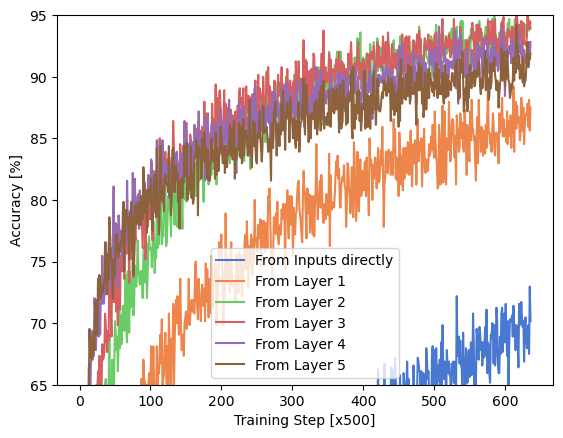

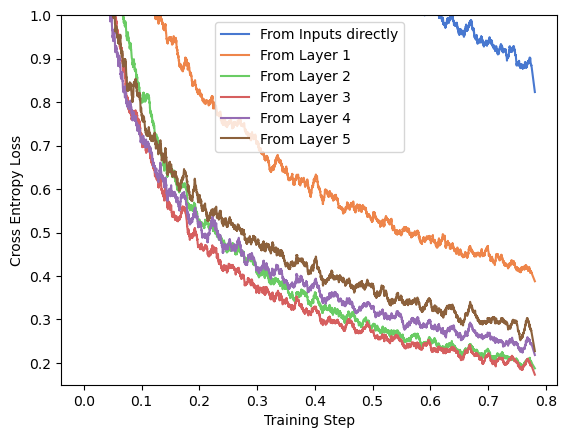

In [34]:
print(f'Accuracy of last quarter: {100*acc[-len(acc)//4:].mean(axis=0)}%')
plt.figure()
for i in range(len(acc[0])):
    plt.plot(np.asarray(acc)[:,i]*100, color=color_list[i])
plt.ylabel('Accuracy [%]')
plt.xlabel('Training Step [x500]')
labels = ['From Inputs directly', *[f'From Layer {i+1}' for i in range(len(SNN.layers))]]
plt.legend(labels)
plt.ylim([65, 95])
plt.figure()
print(losses_out.shape)
for i in range(losses_out.shape[1]):
    plt.plot(np.arange(len(losses_out))/len(train_loader), savgol_filter(losses_out[:,i], 99, 1), label=labels[i], color=color_list[i])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Training Step')
plt.ylim([0.15, 1.0])
plt.legend();

## Get output projection Accuracy on test set

  0%|          | 0/36 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 44.92%
From layer 1:
Accuracy: 65.11%
From layer 2:
Accuracy: 72.22%
From layer 3:
Accuracy: 71.86%
From layer 4:
Accuracy: 74.20%
From layer 5:
Accuracy: 72.79%


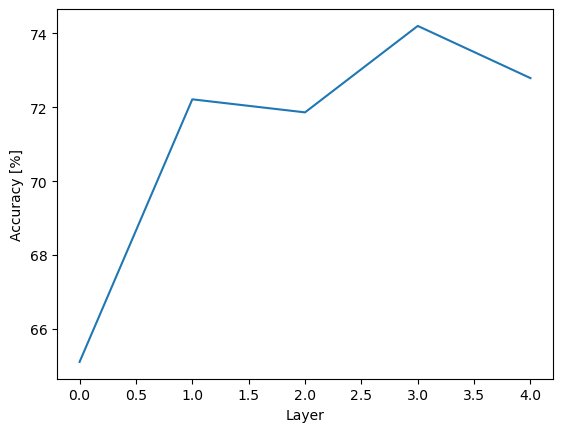

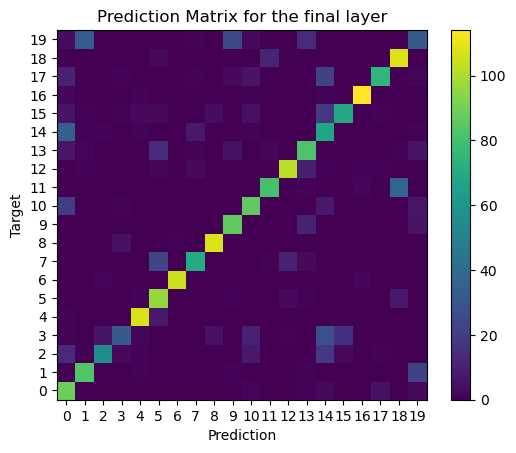

In [7]:
from tqdm.notebook import trange
correct = torch.zeros(len(out_projs))
for out_proj in out_projs:
    out_proj.eval()
no_spk = True
SNN.eval()
pred_matrix = torch.zeros(n_outputs, n_outputs)
for idx in trange(0, len(test_loader), batch_size):
    for out_proj in out_projs:
        out_proj.reset()
    SNN.reset(0)
    inp, target = test_loader.x[idx:idx+batch_size], test_loader.y[idx:idx+batch_size]
    logits = len(out_projs)*[torch.zeros((inp.shape[0],20))]
    for step in range(inp.shape[1]):
        data_step = inp[:,step].float().to(device)
        spk_step, _, _ = SNN(data_step, 0)
        spk_step = [data_step, *spk_step]
        for i, out_proj in enumerate(out_projs):
            out, mem = out_proj(spk_step[i], target)
            if no_spk:
                logits[i] = mem
            else:
                logits[i] = logits[i] + out
    for i, logit in enumerate(logits):
        pred = logit.argmax(axis=-1)
        correct[i] += int((pred == target).sum())
    # for the last layer create the prediction matrix
    for j in range(pred.shape[0]):
        pred_matrix[int(target[j]), int(pred[j])] += 1
correct /= len(test_loader)
print('Directly from inputs:')
print(f'Accuracy: {100*correct[0]:.2f}%')
accs = []
for i in range(len(out_projs)-1):
    print(f'From layer {i+1}:')
    print(f'Accuracy: {100*correct[i+1]:.2f}%')
    accs.append(correct[i+1])

plt.figure()
plt.plot(100*np.asarray(accs))
plt.ylabel('Accuracy [%]')
plt.xlabel('Layer')

plt.figure()
plt.imshow(pred_matrix, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(n_outputs)])
plt.yticks([i for i in range(n_outputs)])
plt.colorbar();

# Few Shot Learning

In [42]:
# Randomly select k sample of each class and save the spiking activity
SNN.reset(0)
one_shot_samples = torch.zeros(n_outputs, n_time_bins, n_inputs)
one_shot_spks = torch.zeros(n_outputs, len(SNN.layers), n_hidden[0])
k = 40
for i in trange(n_outputs):
    for j in range(k):
        img, _ = train_loader.next_item(i, contrastive=False)
        one_shot_samples[i] = img.squeeze()
        for t in range(n_time_bins):
            logits, _, _ = SNN(img[t].float(), None) 
            one_shot_spks[i] += torch.stack(logits).squeeze()

def metric(spk, one_shot):
    dists = torch.zeros(spk.shape[1], n_outputs)
    spk = spk.sum(axis=0)
    for i in range(n_outputs):
        one_shot_i = one_shot[i] / one_shot[i].sum()
        dists[:, i] = torch.einsum('bi, i->b' , spk, one_shot_i)
    return dists

def get_predictions(spks):
    preds = torch.zeros(spks.shape[1], spks.shape[2])
    # for each layer get the prediction
    for i in range(spks.shape[1]):
        dists = metric(spks[:,i], one_shot_spks[:,i])
        preds[i] = dists.argmax(axis=-1)
    return preds

batch = int(len(test_loader)/50)
correct_oneshot = torch.zeros(len(SNN.layers))
SNN.eval()
pred_matrix_oneshot = torch.zeros(n_outputs, n_outputs)
for idx in trange(0, len(test_loader), batch):
    SNN.reset(0)
    inp, target = test_loader.x[idx:idx+batch], test_loader.y[idx:idx+batch]
    logits = torch.zeros(n_time_bins, len(SNN.layers), inp.shape[0], n_hidden[0])
    for step in range(inp.shape[1]):
        data_step = inp[:,step].float().to(device)
        spk_step, _, _ = SNN(data_step, None, 0)
        logits[step] = torch.stack(spk_step)
    preds = get_predictions(logits)
    for i in range(preds.shape[0]):
        correct_oneshot[i] += int((preds[i] == target).sum())
    # for the last layer create the prediction matrix
    for j in range(preds.shape[1]):
        pred_matrix_oneshot[int(target[j]), int(preds[-1, j])] += 1
correct_oneshot /= len(test_loader)
for i in range(len(SNN.layers)):
    print(f'From layer {i+1}:')
    print(f'Accuracy: {100*correct_oneshot[i]:.2f}%')

plt.imshow(pred_matrix_oneshot, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(n_outputs)])
plt.yticks([i for i in range(n_outputs)])
plt.colorbar();

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

TypeError: argument of type 'int' is not iterable